# Decoding movie features from (V1) visual cortex

- this notebook will demo how to use CEBRA on the allen data (shown in Fig. 4, 5).

- Install note: be sure you have cebra, and the demo dependencies, installed to use this notebook: 

In [39]:
import sys

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import torch
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
import cebra.datasets
from cebra import CEBRA
import cebra
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score
import torch.optim as optim
import random
import os 
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from sklearn.decomposition import PCA



In [2]:
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = "cpu"

- Be sure you have downloaded the data and placed `/data` from [FigShare](https://figshare.com/s/60adb075234c2cc51fa3). Let's check if it's there:

## Load the data

- In this example, we load Ca (30 Hz) and Neuropixels (120Hz) recording from pseudomice (stacked neurons from multiple mice), recorded while the Natural Movie1 stimulus (30sec, 30Hz) was passively shown during 10 repeats. 
- Pre-defined CEBRA datasets used for the paper experiments include varied dataset with different "cortex", "seed" and "num_neurons".

- Set "cortex" from ["VISp", "VISpm", "VISam", "VISrl", "VISal", "VISl"], "seed" from [111, 222, 333, 444, 555] and "num_neurons" from [10, 30, 50, 100, 200, 400, 600, 800, 900, 1000]. 

In [3]:
cortex = 'VISp'
seed=333
num_neurons = 800

np_train = cebra.datasets.init(f'allen-movie-one-neuropixel-{cortex}-{num_neurons}-train-10-{seed}')
np_test = cebra.datasets.init(f'allen-movie-one-neuropixel-{cortex}-{num_neurons}-test-10-{seed}')


In [4]:
np_train_grouped = np_train.neural.numpy().reshape(-1, 4, 800).mean(axis=1)
np_test_grouped = np_test.neural.numpy().reshape(-1, 4, 800).mean(axis=1)

In [5]:
neurons_to_remove = set()

for i in range(9):
    current_trial = np_train_grouped[i*900: (i+1)*900, :]
    zero_columns = np.all(current_trial == 0, axis=0)
    zero_column_indices = np.where(zero_columns)[0]
    neurons_to_remove.update(zero_column_indices)

neurons_to_remove = list(neurons_to_remove)
np_train_grouped = np.delete(np_train_grouped, neurons_to_remove, axis=1)
np_test_grouped = np.delete(np_test_grouped, neurons_to_remove, axis=1)

In [6]:
np_train_frame_embed = np_train.index.reshape(-1, 4, 768)[:, 0]
np_test_frame_embed = np_test.index.reshape(-1, 4, 768)[:, 0]

In [7]:
train_frame_index_grouped = np_train.frames_index.reshape(-1, 4)[:, 0]
test_frame_index_grouped = np_test.frames_index.reshape(-1, 4)[:, 0]

In [8]:
np_train.neural = torch.tensor(np_train_grouped)
np_test.neural = torch.tensor(np_test_grouped)
np_train.index = np_train_frame_embed
np_test.index = np_test_frame_embed
np_train.frames_index = train_frame_index_grouped
np_test.frames_index = test_frame_index_grouped

## Visualize DINO features of the video frames

- CEBRA datasets include the video frames (Natural movie 1 from Allen Visual Coding) features extracted from a vision transformer model, DINO(https://arxiv.org/abs/2104.14294).
- Here we visualize DINO features using 2D tSNE. 

(np.float64(-46.42596912384033),
 np.float64(45.18930149078369),
 np.float64(-48.28998794555664),
 np.float64(44.41128005981445))

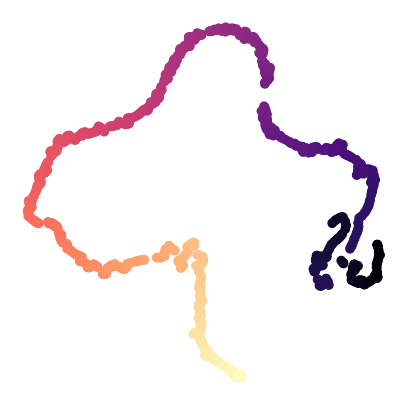

In [ ]:
dino_tsne = TSNE(n_components = 2)
dino_tsne_viz = dino_tsne.fit_transform(np_train.index[:900,:])

fig = plt.figure(figsize = (5,5))
plt.scatter(dino_tsne_viz[:,0], dino_tsne_viz[:,1], cmap = 'magma', c = np.arange(900))
plt.axis('off')

## Train CEBRA models (Ca, Neuropixel, 1 frame window) using DINO features as behavior labels

- We train CEBRA-Behavior models using the DINO video frames features as behavior labels on Ca recording, ephys recording.


In [9]:
## Helper functions to define CEBRA solvers

def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    data_loader.to(kwargs['device'])
    model = cebra.models.init(kwargs['model_architecture'], data_loader.dataset.input_dimension,
                              kwargs['num_hidden_units'],
                              kwargs['output_dimension'], norm).to(kwargs['device'])
    data_loader.dataset.configure_for(model)
    if kwargs['distance'] == 'euclidean':
        criterion = cebra.models.InfoMSE(temperature=kwargs['temperature'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra.models.InfoNCE(temperature=kwargs['temperature'])
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), criterion.parameters()), lr=kwargs['learning_rate'])
    return cebra.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer,
                                            tqdm_on=kwargs['verbose'])

def multi_session_solver(data_loader, **kwargs):
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    for dataset in data_loader.dataset.iter_sessions():
        dataset.to(kwargs['device'])
        
    model = torch.nn.ModuleList([
        cebra.models.init(m, dataset.input_dimension,
                          kwargs['num_hidden_units'], kwargs['output_dimension'], norm)
        for dataset, m in zip(data_loader.dataset.iter_sessions(), kwargs['model_architecture'])
    ]).to(kwargs['device'])
    
    for m in model:
        m.to(kwargs['device'])
    for n, dataset in enumerate(data_loader.dataset.iter_sessions()):
        dataset.configure_for(model[n])
    if kwargs['distance'] == 'euclidean':
        criterion = cebra.models.InfoMSE(temperature=kwargs['temperature'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra.models.InfoNCE(temperature=kwargs['temperature'])
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), criterion.parameters()), lr=kwargs['learning_rate'])
    return cebra.solver.MultiSessionSolver(model=model,
                                           criterion=criterion,
                                           optimizer=optimizer,
                                           tqdm_on=kwargs['verbose'])

@torch.no_grad()
def get_emissions(model, dataset):
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = "cpu"
    model.to(device)
    dataset.configure_for(model)
    return model(dataset[torch.arange(len(dataset))].to(device)).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

def _compute_emissions_multi(solver, dataset):

    return {
        i :
            get_emissions(model, session)
            for i, (model, session) in enumerate(zip(solver.model, dataset.iter_sessions()))
    }

In [10]:
train_steps = 10000

In [11]:
np_loader = cebra.data.ContinuousDataLoader(np_train, num_steps = train_steps, batch_size = 512, conditional = 'time_delta', time_offset = 1)

In [12]:
cebra_np = single_session_solver(data_loader = np_loader, model_architecture = 'resample1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, device = DEVICE, temperature = 1, learning_rate = 3e-4)

In [13]:
cebra_np.fit(np_loader)
cebra_np_emb = _compute_emissions_single(cebra_np, np_train)

pos:  0.0035 neg:  6.2574 total:  6.2609 temperature:  1.0000: 100%|██████████| 10000/10000 [25:16<00:00,  6.59it/s] 


In [14]:
cebra_np_emb.shape

(8100, 128)

(-0.20690188333392143,
 0.22598957046866416,
 -0.26610234156250956,
 0.24830670431256294)

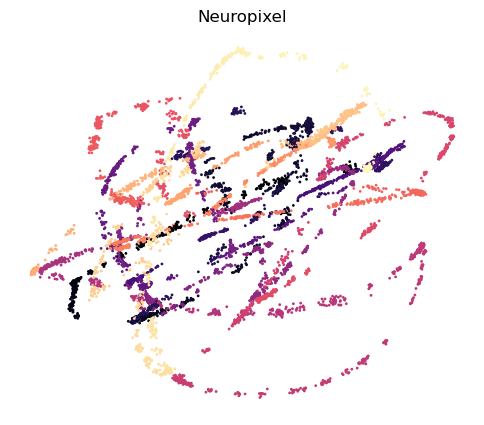

In [74]:
fig = plt.figure(figsize = (6,5))

plt.title('Neuropixel')
plt.scatter(cebra_np_emb[:,0], cebra_np_emb[:,1], cmap = 'magma', c = np.tile(np.arange(900), 9), s=1)
plt.axis('off')

## Decoding movie frame IDs (1 frame window)

- We decode frame IDs (0-900, 30Hz, 30s movie) using CEBRA trained on Neuropixels only, jointly trained CEBRA and mean neural population activity of 1 frame window as a baseline. 
- We use kNN decoder for CEBRA embeddings and kNN & naive Bayes model for baseline decoders. 
- We use the 1-8th repeat as the train set, 9th repeat as the valid set, and the last 10th repeat as test set. 


In [138]:
def allen_frame_id_decode(train_fs, train_labels, test_fs, test_labels, modality = 'neuropixel', decoder = 'knn'):
    time_window = 1  

    if train_fs is None or test_fs is None:
        return [None], [None], None
    if decoder == 'knn':
        params = [1, 2, 5, 10, 25, 50, 100]
    elif decoder == 'bayes':
        params = np.logspace(-9, 3, 5)
    else:
        raise ValueError('Choose decoder between knn or bayes')
    errs = []
    accs = []

    X_test_all_unique = []

    for _ in range(2):
        for i in range(900):
            choices = np.arange(9) * 900 + i
            unused_choices = np.delete(choices, [c in X_test_all_unique for c in choices])
            X_test_all_unique.append(np.random.choice(unused_choices))
    
    X_train = np.delete(train_fs, X_test_all_unique, axis=0)
    y_train = np.delete(train_labels, X_test_all_unique, axis=0)
    X_test = train_fs[X_test_all_unique]
    y_test = train_labels[X_test_all_unique]

    for n in params:
        if decoder == 'knn':
            train_decoder = KNeighborsClassifier(n_neighbors=n,
                                                     metric='cosine')
        elif decoder == 'bayes':
            train_decoder = GaussianNB(var_smoothing = n)
        train_decoder.fit(X_train, y_train)
        pred = train_decoder.predict(X_test)
        err = y_test - pred
        errs.append(abs(err).mean())
        acc = (y_test == pred).sum() / len(y_test)
        accs.append(acc)
    
    if decoder == 'knn':
        test_decoder = KNeighborsClassifier(n_neighbors=params[np.argmin(errs)],
                                                     metric='cosine')
    elif decoder == 'bayes':
        test_decoder = GaussianNB(var_smoothing = params[np.argmin(errs)])

    test_decoder.fit(train_fs, train_labels)
    pred = test_decoder.predict(test_fs)
    frame_errors = pred - test_labels

    quantized_acc = (abs(frame_errors) < time_window).sum() / len(frame_errors)

    return pred, frame_errors, quantized_acc, errs, accs


In [15]:
cebra_np_test = _compute_emissions_single(cebra_np, np_test)

In [16]:
np_train.neural.shape

torch.Size([8100, 772])

In [17]:
cebra_np_train_test = np.concatenate([cebra_np_emb, cebra_np_test], axis=0)
frame_labels = np.tile(np.arange(900), 10)

In [140]:
X_test_all_unique = []

for i in range(900):
    choices = np.arange(9) * 900 + i
    unused_choices = np.delete(choices, [c in X_test_all_unique for c in choices])
    X_test_all_unique.append(np.random.choice(unused_choices))
    
X_train = np.delete(cebra_np_train_test, X_test_all_unique, axis=0)
y_train = np.delete(frame_labels, X_test_all_unique, axis=0)
X_test = cebra_np_train_test[X_test_all_unique]
y_test = frame_labels[X_test_all_unique]

In [ ]:
pred_cebra, errs_cebra, acc_cebra, mae_cebra, acc_cebra_validation = allen_frame_id_decode(X_train, y_train, X_test, y_test, modality = 'neuropixel', decoder = 'knn')


In [142]:
print(f'CEBRA Neuropixel: {acc_cebra:.2f}')

CEBRA Neuropixel: 0.60


In [276]:
output_dir = 'data' 
manifest_path = os.path.join(output_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
nat_movie = cache.get_natural_movie_template(1)

In [279]:
def generate_video_from_np(frame_ids, movie_name):
    import matplotlib.cm as cm
    import matplotlib.animation as animation
    
    arr = nat_movie[frame_ids]

    frames = [] # for storing the generated images
    fig = plt.figure()
    plt.axis('off')

    for i in range(len(arr)):
        frames.append([plt.imshow(arr[i], cmap=cm.Greys_r,animated=True)])

    ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                    repeat_delay=1000)
    ani.save(f'{movie_name}.mp4')
    plt.show()

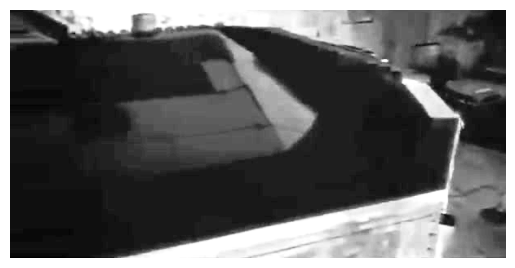

In [280]:
generate_video_from_np(pred_cebra, 'cebra_knn')

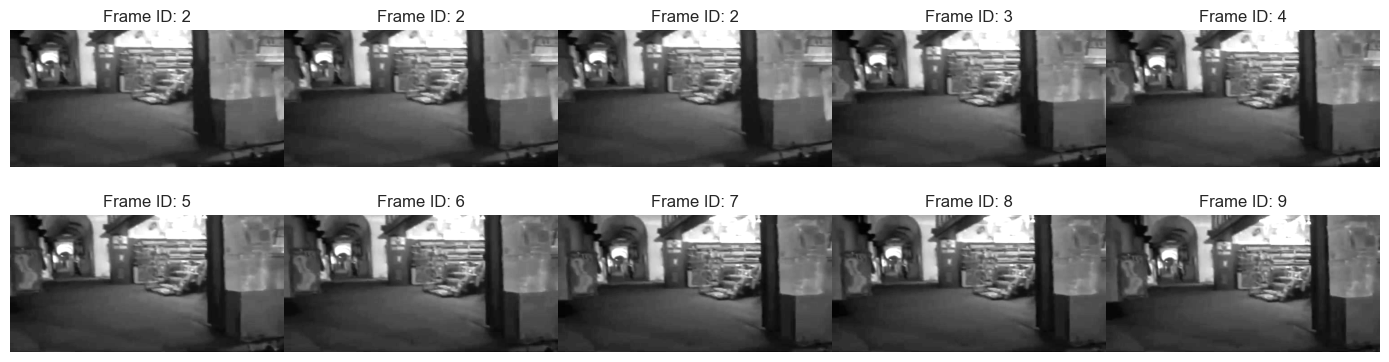

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(14, 4))
ax_flat = ax.flatten()

for i in range(10):
    ax_flat[i].imshow(nat_movie[pred_cebra[i]], cmap='gray')
    ax_flat[i].set_title(f'Frame ID: {pred_cebra[i]}')
    ax_flat[i].axis('off')

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

# plt.savefig('../images/cebra_knn_video.png', bbox_inches='tight', pad_inches=0.1) 
plt.show()

In [148]:
mae_cebra_test = abs(errs_cebra).mean()
mae_cebra_test

0.9377777777777778

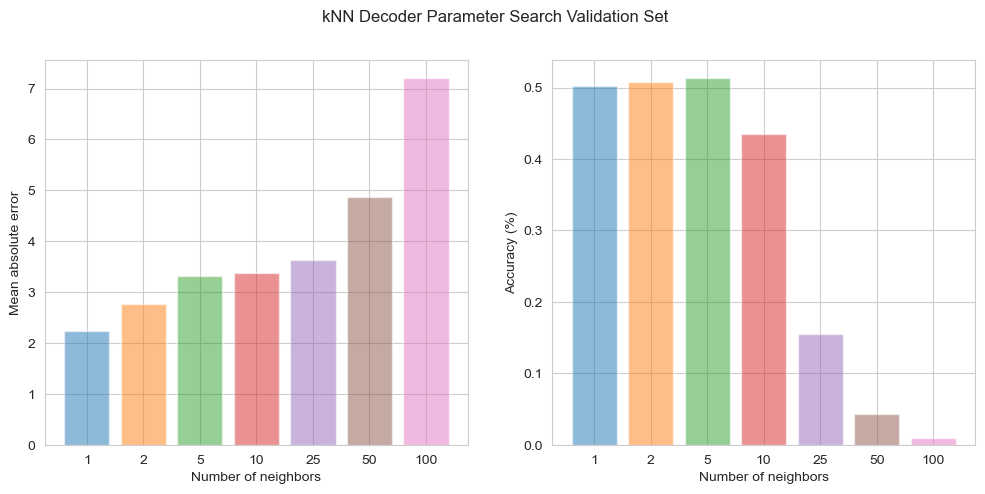

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')

param_values = [1, 2, 5, 10, 25, 50, 100]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

fig, ax = plt.subplots(1, 2, figsize = (12,5))

ax[0].bar(np.arange(len(param_values)), mae_cebra, alpha = 0.5, color = colors)
ax[0].set_xticks(np.arange(len(param_values)), param_values)
ax[0].set_xlabel('Number of neighbors')
ax[0].set_ylabel('Mean absolute error')

ax[1].bar(np.arange(len(param_values)), acc_cebra_validation, alpha = 0.5, color = colors)
ax[1].set_xticks(np.arange(len(param_values)), param_values)
ax[1].set_xlabel('Number of neighbors')
ax[1].set_ylabel('Accuracy (%)')

fig.suptitle('kNN Decoder Parameter Search Validation Set')
# plt.savefig('../images/cebra_latents_knn_decoder_grid_search.png')
plt.show()

In [158]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter = 5000, C=0.4)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_pred_train = lr_model.predict(X_train)
lr_err = y_test - lr_pred
lr_err_train = y_train - lr_pred_train
lr_acc = (y_test == lr_pred).sum() / len(y_test)
lr_acc_train = (y_train == lr_pred_train).sum() / len(y_train)
lr_mae = abs(lr_err).mean()
lr_mae_train = abs(lr_err_train).mean()

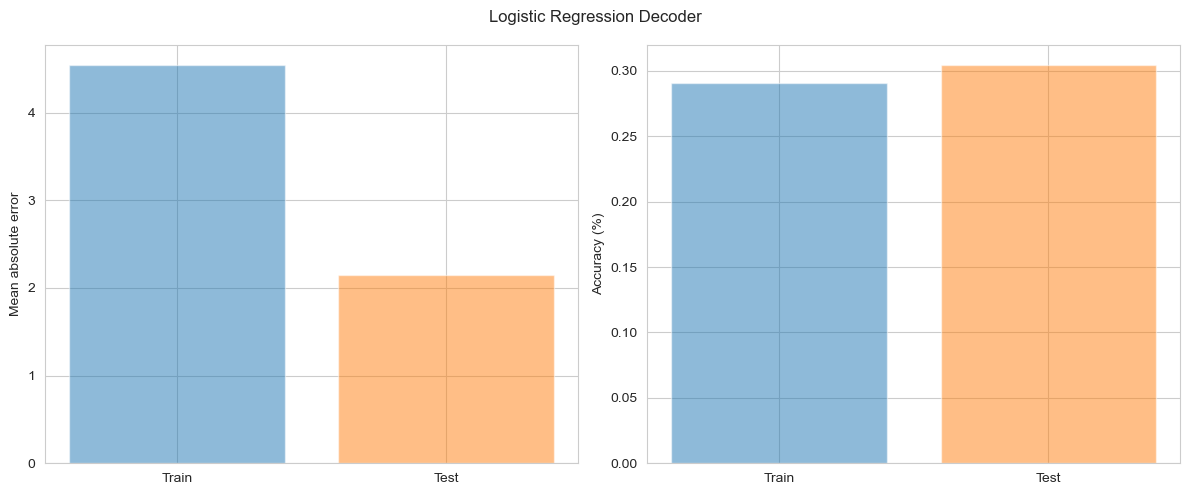

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12,5))
ax_flat = ax.flatten()

ax_flat[0].bar(np.arange(2), [lr_mae_train, lr_mae], alpha = 0.5, color = colors)
ax_flat[0].set_xticks(np.arange(2), ['Train', 'Test'])
ax_flat[0].set_ylabel('Mean absolute error')

ax_flat[1].bar(np.arange(2), [lr_acc_train, lr_acc], alpha = 0.5, color = colors)
ax_flat[1].set_xticks(np.arange(2), ['Train', 'Test'])
ax_flat[1].set_ylabel('Accuracy (%)')

fig.suptitle('Logistic Regression Decoder')
plt.tight_layout()
# plt.savefig('../images/cebra_latents_lr_decoder.png')
plt.show()

In [100]:
mae_cebra

[1.0255555555555556,
 0.9511111111111111,
 1.3988888888888888,
 4.746666666666667,
 9.206666666666667]

In [105]:
np.power(np.linspace(1, 10, 5, dtype=int), 2)

array([  1,   9,  25,  49, 100])

In [33]:
mse_loss = nn.MSELoss(reduction='mean')

class Decoder_Model(nn.Module):
    def __init__(self, x_dim, y_dim):
        super(Decoder_Model, self).__init__()
        self.x_dim = x_dim

        decoder_layers = []
        decoder_hidden_sizes = [350, y_dim, y_dim, y_dim]
        # decoder_hidden_sizes = [350, x_dim]
        # decoder_hidden_sizes = [x_dim, x_dim, x_dim]
        
        prev_size = x_dim
        for i, hidden_size in enumerate(decoder_hidden_sizes):
            decoder_layers.append(nn.Linear(prev_size, hidden_size))
            if i != len(decoder_hidden_sizes) - 1:
                decoder_layers.append(nn.LeakyReLU())
            prev_size = hidden_size

        self.neural_decoder = nn.Sequential(*decoder_layers)

        print(f'Decoder: {self.neural_decoder}')

    def decode(self, z):
        x_hat = self.neural_decoder(z)

        return x_hat

    def forward(self, z):
        decoded_x = self.decode(z)

        # check if decoded x contains NaN values
        if torch.isnan(decoded_x).any():
            print('Decoded X contains NaN values', decoded_x)

        return decoded_x

    def decoder_loss_func(self, x_hat, x):
        mse_x = mse_loss(x_hat, x)

        return mse_x

In [19]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        label = self.labels[idx]
        return item, label

In [20]:
def validate_model_r2(model, latents, x):
  with torch.no_grad():
    # Get the Hidden States
    x_preds = model(latents)

    x_preds_flatten = x_preds.reshape(-1, x_preds.shape[-1])

    x_r2_score_value = r2_score(np.array(x.cpu()), np.array(x_preds_flatten.cpu()))
  
    return x_r2_score_value

In [21]:
def format_loss(loss):
    return f"{loss:,.2f}"

def init_model(latents, X):
    X_test_all_unique = []

    for _ in range(2):
        for i in range(900):
            choices = np.arange(9) * 900 + i
            unused_choices = np.delete(choices, [c in X_test_all_unique for c in choices])
            X_test_all_unique.append(np.random.choice(unused_choices))
    
    X_train = np.delete(latents, X_test_all_unique, axis=0)
    y_train = np.delete(X, X_test_all_unique, axis=0)
    X_test = latents[X_test_all_unique]
    y_test = X[X_test_all_unique]

    decoder_model = Decoder_Model(x_dim=latents.shape[-1], y_dim=X.shape[-1])
    decoder_model.apply(weights_init)

    return X_train, X_test, y_train, y_test, decoder_model

def model_training_and_validating(latents, X, num_epochs=400, silent=False, concat_train_test=False):
    init_args = (latents, X)

    X_train, X_test, y_train, y_test, decoder_model = init_model(*init_args)
    decoder_model.to(DEVICE)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(DEVICE)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(DEVICE)

    optimizer = optim.Adam(decoder_model.parameters(), lr=1e-3)

    x_data = np.concatenate((X_train, X_test), axis=0) if concat_train_test else X_train
    y_data = np.concatenate((y_train, y_test), axis=0) if concat_train_test else y_train

    dataset = CustomDataset(x_data, y_data)
    train_loader = DataLoader(dataset, batch_size=48, shuffle=True)
    loss_keys = ['losses']
    x_train_metrics = ['x_train_r2_scores']
    x_test_metrics = ['x_test_r2_scores']
    losses_dict = {k: [] for k in loss_keys}
    metrics_dict = {k: [] for k in x_train_metrics + x_test_metrics}

    for epoch in range(1, num_epochs + 1):
        decoder_model.train()  
        total_mse_loss = 0

        for i, (latent, neural) in enumerate(train_loader):
            latent = latent.to(DEVICE)
            neural = neural.to(DEVICE)
            
            optimizer.zero_grad()

            x_hat = decoder_model(latent)

            loss = decoder_model.decoder_loss_func(x_hat, neural)
            total_mse_loss += loss.item()

            loss.backward()
            optimizer.step()


        losses_dict['losses'].append(total_mse_loss)

        x_train_r2_score = validate_model_r2(decoder_model, x_data, y_data) if concat_train_test else validate_model_r2(decoder_model, X_train, y_train)
        x_test_r2_score = validate_model_r2(decoder_model, X_test, y_test)

        metrics_dict['x_train_r2_scores'].append(x_train_r2_score)
        metrics_dict['x_test_r2_scores'].append(x_test_r2_score)

        if (epoch % 20 == 0 or epoch == 1) and not silent:
            print(f"Epoch number: {epoch}, train_r2: {format_loss(metrics_dict['x_train_r2_scores'][-1])}, test_r2: {format_loss(metrics_dict['x_test_r2_scores'][-1])}, x_mse: {format_loss(losses_dict['losses'][-1])}")


    return decoder_model, losses_dict, metrics_dict, [X_train, X_test, y_train, y_test]

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu') 


In [22]:
def zscore_2d(arr):
    # Along the time dimension 
    means = np.mean(arr, axis=(0), keepdims=False)
    stds = np.std(arr, axis=(0), keepdims=False)
    
    zscored_arr = (arr - means) / stds
    
    return zscored_arr

In [28]:
X_train = np.concatenate([cebra_np_emb, cebra_np_test], axis=0)
neural_labels = np.concatenate([np_train.neural.cpu(), np_test.neural.cpu()], axis=0)

In [29]:
neural_labels = zscore_2d(neural_labels)

In [257]:
var_neural_labels = np.var(neural_labels, axis=0)
top_var_indices = np.argsort(var_neural_labels)[::-1][:393]
neural_labels = neural_labels[:, top_var_indices]

In [30]:
X_test_all_unique = []

for i in range(900):
    choices = np.arange(9) * 900 + i
    unused_choices = np.delete(choices, [c in X_test_all_unique for c in choices])
    X_test_all_unique.append(np.random.choice(unused_choices))
    
latents_train = np.delete(X_train, X_test_all_unique, axis=0)
neural_train = np.delete(neural_labels, X_test_all_unique, axis=0)
latents_test = X_train[X_test_all_unique]
neural_test = neural_labels[X_test_all_unique]

In [40]:
pca = PCA(n_components=3)
pca_latents_test = pca.fit_transform(latents_test)

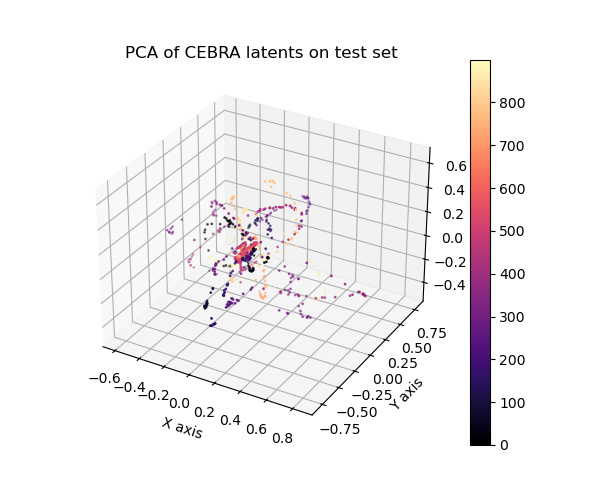

In [44]:
%matplotlib widget

fig = plt.figure(figsize = (6,5))
ax = fig.add_subplot(111, projection='3d')
# plt.title('Neuropixel')
scatter = ax.scatter(pca_latents_test[:,0], pca_latents_test[:,1], pca_latents_test[:,2], cmap = 'magma', c = np.arange(900), s=1)
plt.colorbar(scatter)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
# plt.axis('off')
plt.title('PCA of CEBRA latents on test set')
plt.show()

In [31]:
def set_seed(seed):
    # Set seed for Python's built-in random module
    random.seed(seed)
    
    # Set seed for NumPy
    np.random.seed(seed)
    
    # Set seed for PyTorch (CPU and GPU)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    
    # Ensure reproducibility of CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Disable the auto-tuner that selects the best algorithm for hardware

    # For better reproducibility in PyTorch's random operations
    torch.use_deterministic_algorithms(True)

In [34]:
seed = 2020
set_seed(int(seed))
print("model results of seed: ", seed)
args = {
   'latents': latents_train, 
    'X': neural_train,
    'num_epochs': 200, 
    'silent': False,
    'concat_train_test': False
}
vae_model, losses_dict, metrics_dict, data_split = model_training_and_validating(**args)

model results of seed:  2020
Decoder: Sequential(
  (0): Linear(in_features=128, out_features=350, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=350, out_features=772, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=772, out_features=772, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=772, out_features=772, bias=True)
)
Epoch number: 1, train_r2: 0.07, test_r2: 0.06, x_mse: 126.26
Epoch number: 20, train_r2: 0.11, test_r2: 0.07, x_mse: 118.58
Epoch number: 40, train_r2: 0.13, test_r2: 0.06, x_mse: 116.27
Epoch number: 60, train_r2: 0.14, test_r2: 0.05, x_mse: 113.76
Epoch number: 80, train_r2: 0.16, test_r2: 0.04, x_mse: 111.59


KeyboardInterrupt: 

In [270]:
x_test_preds = vae_model(torch.tensor(latents_test, dtype=torch.float32).to(DEVICE))

In [271]:
r2_test = r2_score(np.array(neural_test), np.array(x_test_preds.detach().cpu()).reshape(-1, neural_test.shape[-1]))

In [272]:
r2_test

0.019364237785339355

772 neurons: .019
503 neurons: .065
393 neurons: .070

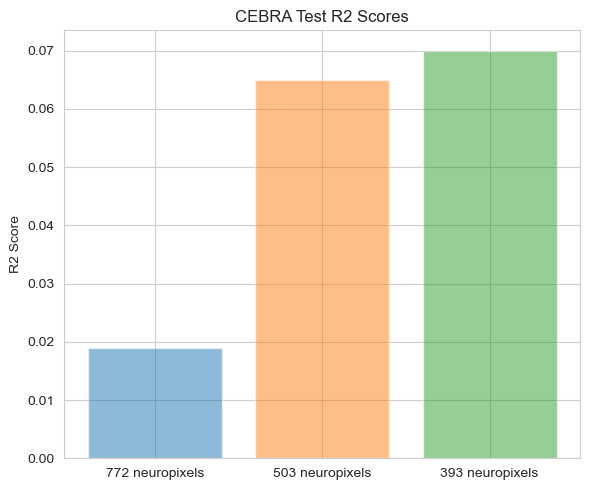

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
labels = ['772 neuropixels', '503 neuropixels', '393 neuropixels']
r2_scores = [0.019, 0.065, 0.070]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

fig, ax = plt.subplots(figsize = (6,5))
ax.bar(labels, r2_scores, color = colors, alpha = 0.5)
ax.set_ylabel('R2 Score')
ax.set_title('CEBRA Test R2 Scores')
plt.tight_layout()

# plt.savefig('../images/cebra_test_r2_scores.png')
plt.show()



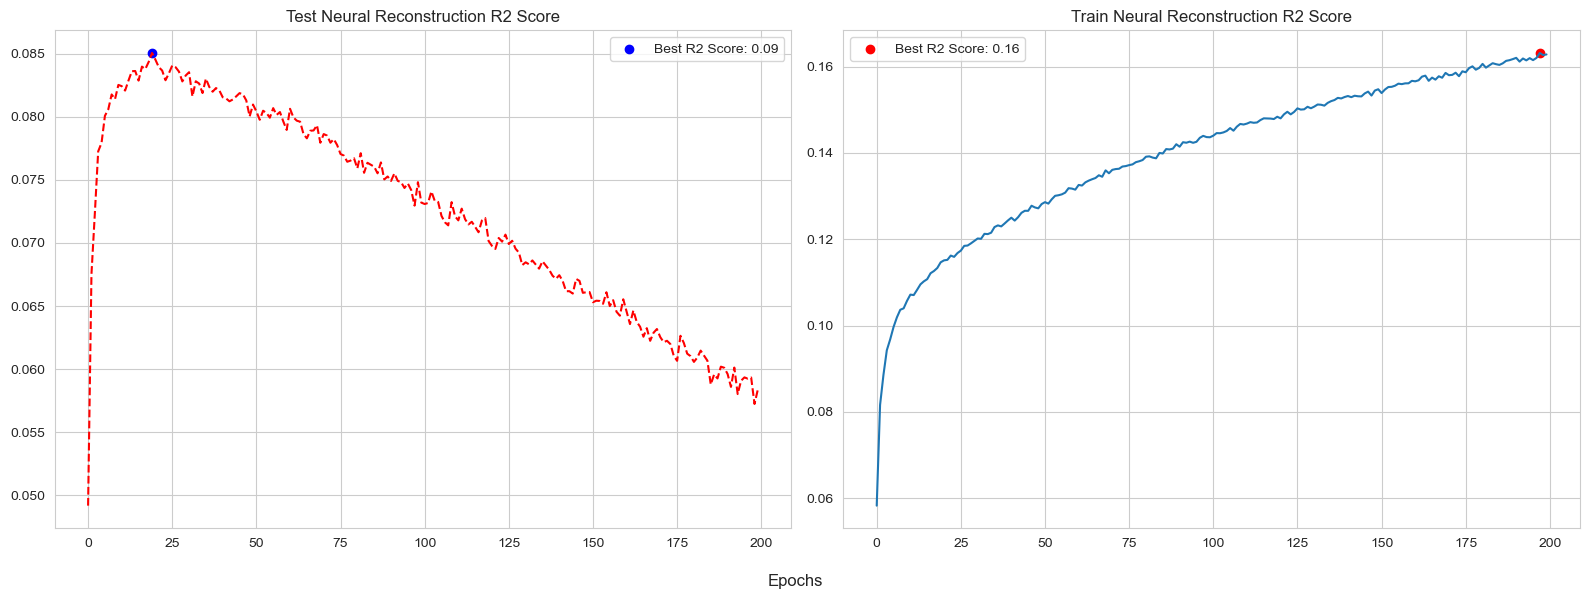

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")
fig, axs = plt.subplots(1,2, figsize=(16, 6))
axs[0].plot(metrics_dict['x_test_r2_scores'], linestyle='dashed', color='red')
axs[1].plot(metrics_dict['x_train_r2_scores'])
axs[0].set_title('Test Neural Reconstruction R2 Score')
axs[1].set_title('Train Neural Reconstruction R2 Score')
fig.supxlabel('Epochs')
best_x = np.argmax(metrics_dict['x_test_r2_scores'])
best_y = np.max(metrics_dict['x_test_r2_scores'])
best_x_train = np.argmax(metrics_dict['x_train_r2_scores'])
best_y_train = np.max(metrics_dict['x_train_r2_scores'])
axs[0].scatter(best_x, best_y, color='blue', label=f'Best R2 Score: {best_y:.2f}')
axs[0].legend()
axs[1].scatter(best_x_train, best_y_train, color='red', label=f'Best R2 Score: {best_y_train:.2f}')
axs[1].legend()
plt.tight_layout()
# plt.savefig('../images/cebra_x_r2_393_200_epochs_3_layer.png')
plt.show()

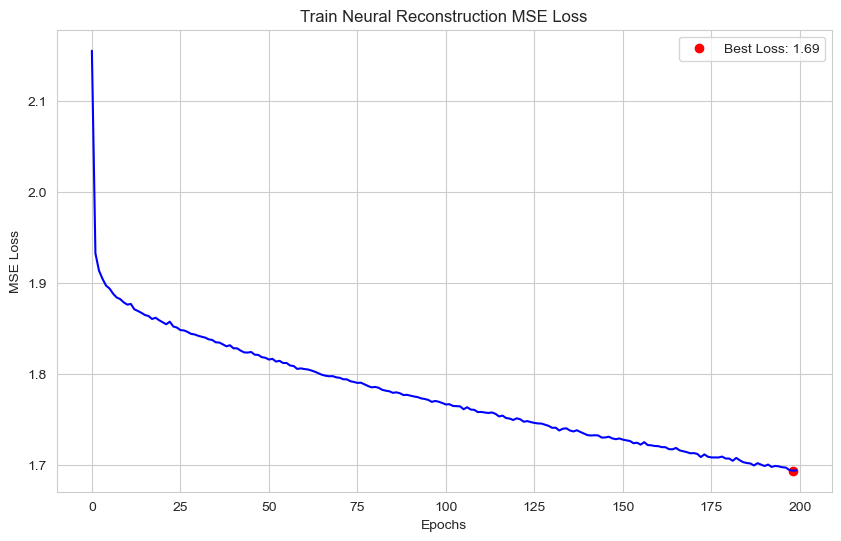

In [222]:
import seaborn as sns
sns.set_style("whitegrid")
fig = plt.figure(figsize=(10, 6))

plt.plot(losses_dict['losses'], color='blue')
plt.title('Train Neural Reconstruction MSE Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')

best_x = np.argmin(losses_dict['losses'])
best_y = np.min(losses_dict['losses'])
plt.scatter(best_x, best_y, color='red', label=f'Best Loss: {best_y:.2f}')
plt.legend()

plt.savefig('../images/cebra_x_mse_772_200_epochs_3_layer.png')
plt.show()
